# Generative AI / Machine Learning Use Cases

* Some demos on how to use large language models for various prototypical business use cases
* Comparison of GPT-3 v. other models, and when you might want to use one over the other

First, we need to import a few things:

In [2]:
import transformers
import os
import openai
from dotenv import load_dotenv
import time
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import tiktoken
from IPython.display import display, HTML
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb
import json
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

OPENAI_COST_PER_1K_TOKENS = {
    'text-davinci-003' : {
        'input' : 0.02,
        'output' : 0.02,
    },
    'gpt-3.5-turbo' : {
        'input' : 0.0015,
        'output' : 0.002,
    },
    'text-embedding-ada-002' : {
        'input' : 0.0004,
    }
}

/Users/mwornow/anaconda3/envs/use_cases/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def get_first_number(string):
  # Parse first number in response
  match = re.search(r'\d+', string)
  if match:
      return int(match.group())
  else:
      return None

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

def mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray):
  return trunc(np.mean(np.absolute(y_true - y_pred)), decs=3)
  
def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray):
  return trunc(np.mean((y_true - y_pred) ** 2), decs=3)

def accuracy(y_true: np.ndarray, y_pred: np.ndarray):
  return trunc(np.mean(y_true == y_pred), decs=3)

def print_wrapped(string: str):
  display(HTML('--------<br /><i><span style="font-size:10px">' + string + '</span></i><br />--------'))
  
def send_gpt3_request(prompt: str, **kwargs):
  response = openai.Completion.create(
    model="text-davinci-003",
    prompt=prompt,
    temperature=0,
    max_tokens=kwargs.get('max_tokens', 60),
    top_p=1.0,
    frequency_penalty=0.5,
    presence_penalty=0.0,
  )
  return response

def send_gpt4_request(prompt: str, **kwargs):
  response = openai.Completion.create(
    model="gpt-4-32k",
    prompt=prompt,
    temperature=0,
    max_tokens=kwargs.get('max_tokens', 60),
    top_p=1.0,
    frequency_penalty=0.5,
    presence_penalty=0.0,
  )
  return response

# Sentiment Analysis / Review Classification

**Business Scenario:** 
- You own a small restaurant with thousands of Yelp reviews, and want to a way to automatically quantify the reviews so that you can identify the most negative/positive reviews and improve your restaurant.
- Or, you run a movie production company and want to understand what critics / fans are saying about your movie across the Internet.
- Or, you have a set of medical notes and need to classify each note according to some pre-defined billing schema.

**Task:** 
- Given a set of restaurant reviews, assign a star rating to each review (1-5 stars), where 5 is the most positive and 1 is the most negative.

**Methods:**
1. Prompt Engineering with GPT-3 Instruct
2. Open Source Review Classifier from HuggingFace (BERT-base finetuned on Yelp reviews)

**Dataset:** 
- 1000 Yelp Reviews

**Metrics:** 
1. Accuracy -- How often the model predicts the exact star rating
2. Mean Squared Error -- How far off the model is from the exact star rating (i.e. predicting 4 for a 5 star review is better than predicting 1 for a 5 star review).

In [71]:
# Load dataset
df = pd.read_parquet('data/yelp/yelp_review_full-test.parquet')
dataset = df[:1000]
dataset

,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...
...,...,...
995,1,The service is rude here. They are impersonal ...
996,4,I have been ordering food from Rainbow Garden ...
997,1,meh.\n\nif you are into hanging out with as ma...
998,4,The better of the two Asian grocery stores on/...


In [ ]:
# Run GPT-3 sentiment analysis
def sentiment_analysis_gpt3(review: str):
  prompt = f"You are given the Yelp review for a restaurant. Determine how many stars were associated with this review on an integer scale of 0 to 4, where 0 is the most negative review and 4 is the most positive review.\n\Review: \"{review}\"\nStars:"
  response = send_gpt3_request(prompt)
  input_tokens = response['usage']['prompt_tokens']
  output_tokens = response['usage']['completion_tokens']
  return response['choices'][0]['text'].lower(), input_tokens, output_tokens

gpt3_ratings = []
input_tokens: int = 0
output_tokens: int = 0
start = time.time()
for i, row in tqdm(dataset.iterrows()):
  review = row['text']
  sentiment, input_tokens, output_tokens = sentiment_analysis_gpt3(review)
  gpt3_ratings.append(get_first_number(sentiment))
  input_tokens += input_tokens
  output_tokens += output_tokens
end = time.time()
gpt3_ratings = np.array(gpt3_ratings)

In [74]:
# Get GPT-3 Stats
total_cost: float = OPENAI_COST_PER_1K_TOKENS['text-davinci-003']['input'] * input_tokens / 1000 + OPENAI_COST_PER_1K_TOKENS['text-davinci-003']['output'] * output_tokens / 1000
total_time = end - start
print("Accuracy:", accuracy(dataset['label'], gpt3_ratings))
print("MSE:", mean_squared_error(dataset['label'], gpt3_ratings))
print("Total cost ($):", total_cost)
print("Total time (s):", total_time)

Accuracy: 0.412
MSE: 0.903
Total cost ($): 0.0061600000000000005
Total time (s): 517.238921880722


In [75]:
# 2. HF Sentiment Classifier (fine tuned for review classification)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("rttl-ai/bert-base-uncased-yelp-reviews")
model = AutoModelForSequenceClassification.from_pretrained("rttl-ai/bert-base-uncased-yelp-reviews")
sentiment_analysis_hf = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [76]:
# Run HuggingFace sentiment analysis
start = time.time()
hf_results = sentiment_analysis_hf([ x[:512] for x in dataset['text'].tolist() ])
hf_ratings = np.array([ get_first_number(x['label']) for x in hf_results ])
end = time.time()

In [77]:
# Get HuggingFace Stats
total_cost: float = 0
total_time = end - start
print("Accuracy:", accuracy(dataset['label'], hf_ratings))
print("MSE:", mean_squared_error(dataset['label'], hf_ratings))
print("Total cost ($):", total_cost)
print("Total time (s):", total_time)

Accuracy: 0.678
MSE: 0.378
Total cost ($): 0
Total time (s): 142.79206824302673


#### Conclusion

The open source HuggingFace model is the better choice for this task. Compare to GPT-3 at classifying 1000 restaurant reviews, the HuggingFace model was faster (142 seconds v. 517 seconds) and more accurate (68% v. 41%). The cost difference was negligible.

# Text Summarization / Translation

**Business Scenario:** 
- You have a long, boring document containing the terms of a standard real estate lease, and want a way to quickly summarize the document so that you can get the gist of it without reading the whole thing.
- Or, you have a paragraph excerpt from a highly technical manual. You want to summarize/paraphrase the content in a way that a child could understand.
- Or, you have a document written in Spanish that you'd like translated and summarized in English.

**Task:** 
- Given a document, create a paragraph summarizing the document.

**Methods:**
1. Prompt Engineering with GPT-3 Instruct

**Dataset:** 
- US Declaration of Independence

**Metrics:**
1. The eye test

Lets summarize the Declaration of Independence!

In [11]:
# Load the document
doc = open("data/summarization/declaration.txt", "r").read()
enc = tiktoken.encoding_for_model("text-davinci-003")
print("# of tokens:", len(enc.encode(doc)))

# of tokens: 1684


Get a 3 sentence summary of the US Declaration of Independence.

In [14]:
prompt = f"Summarize the following document in 3 sentences:\n\n{doc}\n\nSummary:"
response = send_gpt3_request(prompt, max_tokens=200)
print_wrapped(response['choices'][0]['text'])

Get a 3 sentence summary of the US Declaration of Independence, written in terms a 2nd grader could understand.

In [15]:
prompt = f"Summarize the following document in 3 sentences using terms that a 2nd grade student would be able to understand:\n\n{doc}\n\nSummary:"
response = send_gpt3_request(prompt, max_tokens=200)
print_wrapped(response['choices'][0]['text'])

Now lets summarize A Midsummer Night's Dream by Shakespeare.

In [18]:
# Load the document
doc = open("data/summarization/shakespeare.txt", "r").read()
enc = tiktoken.encoding_for_model("text-davinci-003")
print("# of tokens:", len(enc.encode(doc)))

# of tokens: 27903


In [19]:
prompt = f"Please summarize the following document in a paragraph:\n\n{doc}\n\nSummary:"
try:
    response = send_gpt3_request(prompt, max_tokens=200)
except Exception as e:
    print(e)

This model's maximum context length is 4097 tokens, however you requested 28117 tokens (27917 in your prompt; 200 for the completion). Please reduce your prompt; or completion length.


Unfortunately, this document is too long to fit into GPT-3's context window. 

We can get around this by either (1) hitting GPT-4 (context 32k, which is not yet available) or (2) splitting the document into chunks and summarizing each chunk individually.

In [20]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 3000,
    chunk_overlap  = 20,
    length_function = lambda x: len(tiktoken.encoding_for_model("text-davinci-003").encode(x)),
    add_start_index = True,
)
texts = text_splitter.create_documents([doc])
print("Split document into", len(texts), "chunks\n\n")
summaries = []
for idx, text in enumerate(texts):
    prompt = f"Please summarize the following document in at most 5 sentences:\n\n{text}\n\nSummary:"
    response = send_gpt3_request(prompt, max_tokens=400)
    summary: str = response['choices'][0]['text']
    summaries.append(summary)
    print_wrapped(str(idx + 1) + '. ' + summary)

# Get one final summary
prompt = f"Please summarize the following paragraph in at most 5 sentences:\n\n{' '.join(summaries)}\n\nSummary:"
response = send_gpt3_request(prompt, max_tokens=400)
print("-- Final Summary --")
print_wrapped(response['choices'][0]['text'])

Split document into 11 chunks




-- Final Summary --


#### Conclusion

GPT-3 can fairly effectively modify the tone / voice / style / complexity of its response. This can be useful for applications like summarization or tutoring.

However, you might get limited by the model's context window (~4k tokens for GPT-3). If you need to process a longer document, you will need to split it into chunks and process each chunk individually.

# Document Retrieval / Question Answering

We consider two scenarios: a PUBLIC corpus of documents and a PRIVATE corpus.

**Business Scenario:** 
- You have a large corpus of company documents (e.g. FAQs, employee handbooks, etc.) that your customer service team uses to answer customer questions. However, finding the right answer within a seas of thousands of potential documents is hard -- it can take a customer service rep up to 10 minutes to Cmd+F their way to the right answer. Oftentimes, they will just give up.
- Or, you want to create a custom "Google search" purpose-built for your company to serve as an internal knowledge base for employees, with the ability to intelligently answer natural language queries.

**Task:** 
- Given a corpus of documents and a query, identify the most relevant document and extract the answer to the query from the document.

**Methods:**
1. Vector database + embeddings
    - GPT-3 (public data)
    - MiniLM (private data)

**Dataset:** 
- Public - ~2k excerpts from Wikipedia articles taken from SQuAD (Stanford Question Answering Dataset)
- Private - SQuAD again, but this time we'll pretend its a proprietary dataset that can't leave our computers

**Metrics:**
1. Top-1 Accuracy -- how often the document with the correct answer is the first result returned

First, let's set up our dataset.

In [22]:
# Convert SQuAD to df and pretend it's a corpus of documents
def squad_json_to_df(file_path, record_path=['data','paragraphs','qas','answers']) -> pd.DataFrame:
    file = json.loads(open(file_path).read())
    # parsing different level's in the json file
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file,record_path[:-2])
    # combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id','question','context','answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

df_squad = squad_json_to_df('data/doc_qa/squad-dev-v1.1.json')
df_docs = df_squad[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
df_docs

,context,c_id
0,Super Bowl 50 was an American football game to...,0
1,The Panthers finished the regular season with ...,1
2,The Broncos took an early lead in Super Bowl 5...,2
3,"CBS broadcast Super Bowl 50 in the U.S., and c...",3
4,"In early 2012, NFL Commissioner Roger Goodell ...",4
...,...,...
2062,"where is the mass of the object, is the velo...",2062
2063,A conservative force that acts on a closed sys...,2063
2064,"For certain physical scenarios, it is impossib...",2064
2065,The connection between macroscopic nonconserva...,2065


In [23]:
# Show an example question + document
print_wrapped('Question: ' + df_squad[df_squad['c_id'] == 0]['question'].values[0])
print_wrapped('Relevant Document: ' + df_docs['context'].values[0])

Next, set up our vector database to store embeddings.

An embedding is simply a numeric representation of a document. Since AI models can only understand numbers (not text), it allows the model to compare documents to each other.

In [24]:
# Create vectorDB to hold embeddings
from chromadb.config import Settings
from chromadb.utils import embedding_functions

os.makedirs('chroma/', exist_ok=True)
chroma_client = chromadb.Client(Settings(
    chroma_db_impl="duckdb+parquet",
    persist_directory='chroma/'
))

def retrieve_documents(collection, question: str):
    # Function to retrieve most relevant documents for a given `question` from the vector DB `collection`
    response = collection.query(
        query_texts=[ question ],
        n_results=2,
        include=["documents", "distances"],
    )

    print("Question:")
    print_wrapped(question)

    print("Relevant documents:")
    for idx, x in enumerate(response['documents'][0]):
        score = "{:.2f}".format(response["distances"][0][idx])
        print_wrapped(f'#{idx + 1} (distance={score}): {x}')


### Public Dataset

Here, we simulate having a public (i.e. non-proprietary dataset). 

We use GPT-4 to embed our documents, save them in a local vector store, and then retrieve the most relevant document.

In [25]:
# Use OpenAI to generate embeddings for documents
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
    api_key=openai.api_key,
    model_name="text-embedding-ada-002",
)
public_collection = chroma_client.create_collection(name="public", embedding_function=openai_ef)

In [26]:
# Embed all SQuAD documents using OpenAI
start = time.time()
for chunk in range(0, df_docs.shape[0], 200):
    # NOTE: Need to chunk to avoid OpenAI API limits
    public_collection.add(
        documents=df_docs['context'].tolist()[chunk:chunk+200],
        ids=df_docs['c_id'].astype(str).tolist()[chunk:chunk+200],
    )
end = time.time()

total_time = end - start
tokenization = tiktoken.encoding_for_model("text-embedding-ada-002").encode_ordinary_batch(df_docs['context'].tolist())
total_tokens = sum([ len(x) for x in tokenization ])
print("Total cost ($)", OPENAI_COST_PER_1K_TOKENS['text-embedding-ada-002']['input'] * total_tokens / 1000)
print("Total time (s):", total_time)

Total cost ($) 0.1334408
Total time (s): 15.911481142044067


In [27]:
random.seed(1)
retrieve_documents(public_collection, df_squad.iloc[0]['question'])
retrieve_documents(public_collection, df_squad.iloc[random.randint(0, df_squad.shape[0])]['question'])
retrieve_documents(public_collection, df_squad.iloc[random.randint(0, df_squad.shape[0])]['question'])

Question:


Relevant documents:


Question:


Relevant documents:


Question:


Relevant documents:


### Private Dataset

Here, we simulate having a proprietary dataset that CANNOT be shared with OpenAI. This reflects the use case for medical data, financial data, and other sensitive data.

We use a locally hosted open source model called MiniLM to embed our documents, save them in a local vector store, and then retrieve the most relevant document.

In [28]:
# Use local open source model to generate embeddings for documents
local_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
private_collection = chroma_client.create_collection(name="private", embedding_function=local_ef)

In [29]:
# Embed all SQuAD documents using local model
start = time.time()
private_collection.add(
    documents=df_docs['context'].tolist(),
    ids=df_docs['c_id'].astype(str).tolist(),
)
end = time.time()

total_time = end - start
print("Total cost ($)", 0)
print("Total time (s):", total_time)

Total cost ($) 0
Total time (s): 52.004509925842285


In [30]:
random.seed(1)
retrieve_documents(private_collection, df_squad.iloc[0]['question'])
retrieve_documents(private_collection, df_squad.iloc[random.randint(0, df_squad.shape[0])]['question'])
retrieve_documents(private_collection, df_squad.iloc[random.randint(0, df_squad.shape[0])]['question'])

Question:


Relevant documents:


Question:


Relevant documents:


Question:


Relevant documents:


### Comparison between GPT-3 and MiniLM

Now let's do a more quantiative comparison between the performance of GPT-3 and MiniLM on Document QA with the SQuAD dataset using Top-1 Accuracy. 

In other words, how often does each model return the correct document for the given question as its #1 result?

In [234]:
# Measure accuracy of OpenAI vs local model on Top-1 retrieval
questions = df_squad['question'].tolist()

## OpenAI
openai_preds = []
for chunk in tqdm(range(0, len(questions), 200)):
    openai_response = public_collection.query(
        query_texts=questions[chunk:chunk+200],
        n_results=1,
        include=["documents"],
    )
    openai_preds += [ int(openai_response['ids'][x][0]) for x in range(len(openai_response['ids'])) ]

## Local model
local_response = private_collection.query(
    query_texts=questions,
    n_results=1,
    include=["documents"],
)
local_preds = [ int(local_response['ids'][x][0]) for x in range(len(local_response['ids'])) ]

openai_preds = np.array(openai_preds)
local_preds = np.array(local_preds)
print("OpenAI Accuracy:", accuracy(df_squad['c_id'], openai_preds))
print("Local Accuracy:", accuracy(df_squad['c_id'], local_preds))

100%|██████████| 53/53 [00:41<00:00,  1.28it/s]


OpenAI Accuracy: 0.668
Local Accuracy: 0.6


We see that OpenAI embeddings are more accurate than MiniLM embeddings by a fair margin.

However, MiniLM is much cheaper (free), faster, and can be used for proprietary data. Thus, the best approach will depend on your specific use case.

# Time Series Prediction

Note: Tutorial taken from: [https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html](https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)

**Business Scenario:** 
- You run a profitable utility company and want to forecast energy usage so that you can plan your energy production and distribution
- Or, you are predicting the price of an asset over time.
- Or, you run the ER room of a hospital and want to use vital signs to predict patient deterioration  before it actually occurs.

**Task:** 
- Given a set of historical energy usage data, predict future energy usage.

**Methods:**
1. Autoregressive forecasting model for time series data (not GPT-3!)

**Dataset:** 
- Electricity demand (MW) dataset for the state of Victoria, Australia, from 2011-12-31 to 2014-12-31 

**Metrics:**
1. Mean Absolute Error -- how far our predictions are from the ground truth electricity usage

#### Quick Aside

How can we use GPT-3 to tackle this time series prediction problem?

The answer is **you shouldn't!** 

This task has nothing to do with natural language processing.

Instead, we'll use an autoregressive model purpose-built for time series forecasting. We will use the `skforecast` Python library for this.

Let's start by loading our dataset.

In [255]:
# Get dataset
df_elec = pd.read_csv('data/time_series/vic_elec.csv')
df_elec.info()

# Do some preprocessing
df_elec['Time'] = pd.to_datetime(df_elec['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df_elec = df_elec.set_index('Time').asfreq('30min').sort_index()
df_elec = df_elec.drop(columns=['Date'])
df_elec = df_elec.resample(rule='H', closed='left', label ='right').mean()
df_elec = df_elec.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()

# Train/test/val splits
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
df_train = df_elec.loc[: end_train, :].copy()
df_val   = df_elec.loc[end_train:end_validation, :].copy()
df_train_val = df_elec.loc[:end_validation,:].copy()
df_test  = df_elec.loc[end_validation:, :].copy()
print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


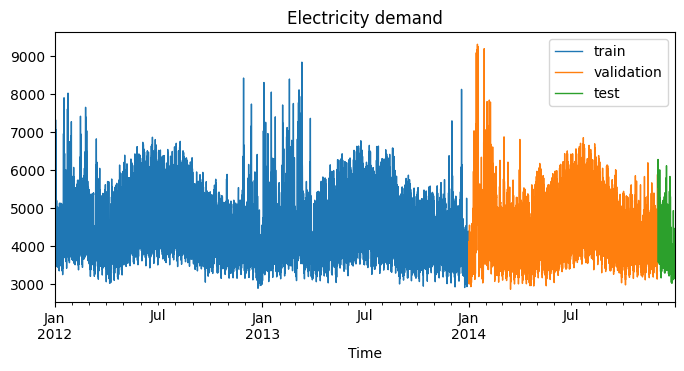

In [246]:
# Plot data
fig, ax = plt.subplots(figsize=(8, 3.5))
df_train.Demand.plot(ax=ax, label='train', linewidth=1)
df_val.Demand.plot(ax=ax, label='validation', linewidth=1)
df_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend()
plt.show()

Now that we have our dataset, let's actually train a model to predict future electricity demand.

We'll be using a linear regression model with L2 regularization ("Ridge"). We'll use the previous 24 hours to inform our prediction at each timestep.

In [301]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Use basic Ridge regression as model
forecaster = skforecast.ForecasterAutoreg.ForecasterAutoreg(
    regressor     = Ridge(random_state=123),
    lags          = 48,
    transformer_y = StandardScaler()
)

# Hyperparam tuning
lags_grid = [5, 24, 48, [1, 2, 3, 23, 24, 25, 47, 48, 49]]
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = df_train_val['Demand'],
    steps              = 48,
    metric             = 'mean_absolute_error',
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    initial_train_size = df_train.shape[0],
    refit              = False,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True,
)

forecaster

Number of models compared: 40.


lags grid: 100%|██████████| 4/4 [00:25<00:00,  6.38s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 346.49704969030336



ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-07-15 18:10:57 
Last fit date: 2023-07-15 18:11:22 
Skforecast version: 0.9.1 
Python version: 3.10.12 
Forecaster id: None 

In [302]:
# Make predictions on test set
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df_elec['Demand'],
    steps              = 48, # Make predictions one day out
    metric             = 'mean_absolute_error',
    initial_train_size = df_train_val.shape[0],
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True,
)

100%|██████████| 15/15 [00:00<00:00, 234.95it/s]


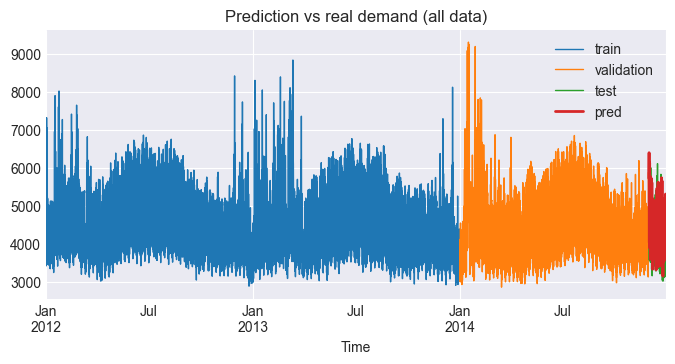

In [303]:
# Plot all the data together
fig, ax = plt.subplots(figsize=(8, 3.5))
df_train.Demand.plot(ax=ax, label='train', linewidth=1)
df_val.Demand.plot(ax=ax, label='validation', linewidth=1)
df_test.Demand.plot(ax=ax, label='test', linewidth=1)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand (all data)')
ax.legend()
plt.show()

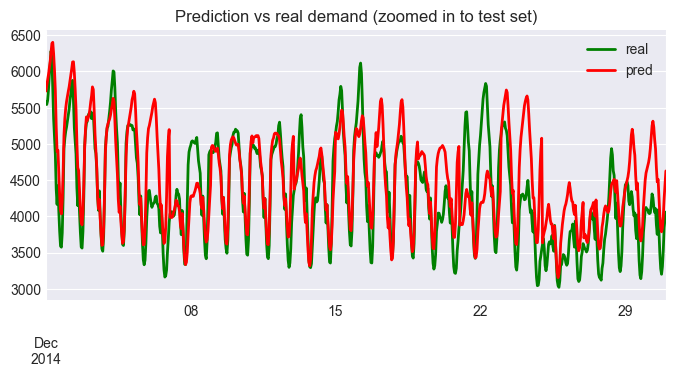

In [304]:
# Zoom in on test set
fig, ax = plt.subplots(figsize=(8, 3.5))
df_elec.loc[predictions.index, 'Demand'].plot(linewidth=2, label='real', ax=ax, color='green')
predictions.plot(linewidth=2, label='prediction', ax=ax, color='red')
ax.set_title('Prediction vs real demand (zoomed in to test set)')
ax.legend()

#### Conclusion

For many predictive tasks, large language models are the wrong tool for the job! Don't fall into the trap of using GPT-3 like a hammer looking for nails.

Use cases that do not involve text will likely require a different modeling approach.